In [4]:
import xarray as xr
import datetime
import numpy as np
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
from pyproj import Proj, Transformer, CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import rasterio
from shapely.geometry import Point
import geopandas as gpd
import os
import glob
from zipfile import ZipFile

In [5]:
toposcale_path = '/Users/jacobqs/Downloads/TopoSCALE_BG.nc'

In [6]:
ds = xr.open_mfdataset(toposcale_path)
ds_raw = ds.copy()

### Dimensions

* Time, t (149016)
* Clusters, clusters (200)
* Pixels, pixels (571612)
* Latitude, latitude (1560)
* Longitude, longitude (1380)


### Time

The data are hourly starting on the 01.01.1999 00:00 UTC and running to 31.12.2015 23:00 UTC

### Coordinates (EPSG:4326)

* Latitude of cluster centroids [degrees N], latc (clusters)
* Longitude of cluster centroids [degrees E], lonc (clusters)
* Latitude of catchment pixels [degrees N], latp (pixels)
* Longitude of catchment pixels [degrees E], lonp (pixels)
* Latitude grid [degrees N], latg (latitude)
* Longitude grid [degrees E], long (longitude)

### Variables and their dimensions and scaling factors

* 2 m air temperature, T (deg C), (t, clusters): 0.01
* Wind speed, U (m/s), (t, clusters): 0.01
* Specific humidity, q (kg/kg), (t, clusters): 10**-6
* Incoming atmospheric shortwave radiation, SW (W/m^2), (t, clusters): 0.1
* Total precipitation, P (mm h-1), (t, clusters): 0.01
* Surface pressure, ps (Pa), (t, clusters): 100
* Cluster number of each pixel, cn (), (pixels)



In [7]:
# Scaling factors

T_sf = 0.01
P_sf = 0.01
U_sf = 0.01
q_sf = 10**-6
SW_sf = 0.1
ps_sf = 100

In [8]:
# Scaling of variables

## Temperature
T_scaled = ds.T * T_sf
ds = ds.assign(T_scaled = T_scaled)

# Precipitation
P_scaled = ds.P * P_sf
ds = ds.assign(P_scaled = P_scaled)

# Wind
U_scaled = ds.U * U_sf
ds = ds.assign(U_scaled = U_scaled)

# Specific humidity
q_scaled = ds.q * q_sf
ds = ds.assign(q_scaled = q_scaled)

# Shortwave down

SW_scaled = ds.SW * SW_sf
ds = ds.assign(SW_scaled = SW_scaled)

# Pressure
ps_scaled = ds.ps * ps_sf
ds = ds.assign(ps_scaled = ps_scaled)


In [9]:
# Converting timestamps, t, to datetime64
dates = []
start_date = datetime.datetime(1999,1,1)
sec_since_epoch = datetime.datetime.timestamp(start_date)
delta_seconds = ds.t.values * 60 * 60

for i in delta_seconds:
    time = sec_since_epoch + i
    time = np.datetime64(datetime.datetime.fromtimestamp(time))
    dates.append(time)


In [10]:
# Switch dimensions from t to time

##Create a new dimension called 'time'
ds = ds.assign_coords(time=dates)



In [11]:
# Creating a new dataset where variables have the new time dimension
ds_new = xr.Dataset(
    data_vars = dict(
        T = (['time', 'clusters'], ds.T.values),
        U = (['time', 'clusters'], ds.U.values),
        q = (['time', 'clusters'], ds.q.values),
        LW = (['time', 'clusters'], ds.LW.values),
        SW = (['time', 'clusters'], ds.SW.values),
        P = (['time', 'clusters'], ds.P.values),
        ps = (['time', 'clusters'], ds.ps.values),
        latc = (['clusters'], ds.latc.values),
        lonc = (['clusters'], ds.lonc.values),
        latp = (['pixels'], ds.latp.values),
        lonp = (['pixels'], ds.lonp.values),
        cn = (['pixels'], ds.cn.values),
        latg = (['latitude'], ds.latg.values),
        long = (['longitude'], ds.long.values),
        mask = (['longitude', 'latitude'], ds.mask.values),
        T_scaled = (['time', 'clusters'], ds.T_scaled.values),
        P_scaled = (['time', 'clusters'], ds.P_scaled.values),
        U_scaled = (['time', 'clusters'], ds.U_scaled.values),
        q_scaled = (['time', 'clusters'], ds.q_scaled.values),
        SW_scaled = (['time', 'clusters'], ds.SW_scaled.values),
        ps_scaled = (['time', 'clusters'], ds.ps_scaled.values),
    ),
    coords = dict(
        time = (['time'], dates)
    )
    
)

# Preparing data for Shyft

Shyft needs:
* Temperature (deg c)
* Precipitation (mm h^-1)
* SW radiation (W m^-2)
* Relative humidity (kg kg^-1)
* Wind speed (m s^-1)

The new dataset already has:
* Temperature (deg C)
* Wind speed (m s^-1)
* SW radiation (W m^-2)
* Precipitation (mm h^-1)

Therefore we only need to get relative humidity. This can be done using the MetPy package

## Converting pressure from Pa to hPa and getting relative humidity

In [12]:
# To use the relative humidity function from MetPy, the surface pressure must be converted from Pa to hPa

ps_scaled_hpa = ds_new.ps_scaled * 0.01
ds_new = ds_new.assign(ps_scaled_hpa = ps_scaled_hpa)

In [13]:
# Getting relative humidity using the MetPy package. 
# NB! Values are in percent and needs to be multiplied by 0.01 to get fraction
rel_hum_values = relative_humidity_from_specific_humidity(ds_new.ps_scaled_hpa.values * units.hPa, 
                                                        ds.T_scaled.values * units.degC, 
                                                        ds.q_scaled.values).to('percent').magnitude * 0.01

## Getting the altitude for each cluster point

We now have all the forcing variables for Shyft. We also need altitude z and convert the coordinates to X, Y

In [14]:
# First we extract the longitudes and latitudes for the clusters 
# (variables have dimension ('time', 'clusters'))

lonc = ds_new.lonc.values
latc = ds_new.latc.values

In [15]:
# Making a list with a tuple of all (lon, lat) points

lonc_latc_points = []

for i in range(len(lonc)):
    lonc_latc_points.append(Point((lonc[i], latc[i])))

In [16]:
# Make a GeoPandas dataframe with all the clusters and points
gdf = gpd.GeoDataFrame(np.arange(len(lonc_latc_points)), geometry = lonc_latc_points, crs = 4326)

In [17]:
# Make a list of all the points (lon, lat)
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

In [18]:
# To get altitude DEM tiles from USGS are merged into one DEM using QGIS and CRS: 4326

## Opening this merged DEM

dem_dataset = rasterio.open('/Users/jacobqs/Documents/MST Himalaya/qgis/DEM/merged_DEM_central_himalaya.tif')

In [19]:
# Sample the coordinate points in coord_list in the DEM file
gdf['value'] = [x for x in dem_dataset.sample(coord_list)]

In [20]:
# Getting a list of all z values
z = []
for i in gdf['value'].values:
    z.append(i[0])


We now have all the z values for each cluster in the GeoPandas dataframe, gdf

## Converting from lat, lon to x, y

In [21]:
## Making a pyproj object for UTM Zone 45N

crs_4326 = CRS.from_epsg(4326) # Lat-lon
crs_32645 = CRS.from_epsg(32645) # CRS 

## Create transformer to convert from CRS to CRS

transformer = Transformer.from_crs(crs_4326, crs_32645, always_xy = True)

x, y = transformer.transform(lonc, latc)

## Making new netcdf files for Shyft

Making a new dataset for each variable to make smaller sized files

In [22]:
home_dir = os.getenv("HOME")
wfde5_path = home_dir + '/Documents/MST Himalaya/WFDE5/'
cell_data_path = glob.glob(wfde5_path + 'cell_data/*.nc')
working_dir = '/Users/jacobqs/Documents/MST Himalaya/MST-Himalaya/'
test_path = working_dir + '/shyft_workspace/shyft-data/netcdf/orchestration-testdata/'
temp_test_path = test_path + 'temperature.nc'
relhum_test_path = test_path + 'relative_humidity.nc'
precip_test_path = test_path + 'precipitation.nc'
swdown_test_path = test_path + 'radiation.nc'
wind_test_path = test_path + 'wind_speed.nc'

In [23]:
temp_test = xr.open_mfdataset(temp_test_path)
relhum_test = xr.open_mfdataset(relhum_test_path)
precip_test = xr.open_mfdataset(precip_test_path)
swdown_test = xr.open_mfdataset(swdown_test_path)
wind_test = xr.open_mfdataset(wind_test_path)
cell_data_test = xr.open_mfdataset(cell_data_path)

In [24]:
ds_temperature = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(ds_new.clusters))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        temperature = (['time', 'station'], ds_new.T_scaled.values)
    ),
    coords = dict(
        time = (['time'], ds_new.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

ds_precipitation = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(ds_new.clusters))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        precipitation = (['time', 'station'], ds_new.P_scaled.values)
    ),
    coords = dict(
        time = (['time'], ds_new.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

ds_wind = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(ds_new.clusters))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        wind_speed = (['time', 'station'], ds_new.U_scaled.values)
    ),
    coords = dict(
        time = (['time'], ds_new.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

ds_radiation = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(ds_new.clusters))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        global_radiation = (['time', 'station'], ds_new.SW_scaled.values)
    ),
    coords = dict(
        time = (['time'], ds_new.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

ds_relhum = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(ds_new.clusters))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        relative_humidity = (['time', 'station'], rel_hum_values)
    ),
    coords = dict(
        time = (['time'], ds_new.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

We now have five datasets (1 for each variables) ready to be made into netcdf formats

In [25]:
# Make a dictionary containing all variables with one dataset for each year
years = ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', 
        '2010', '2011', '2012', '2013', '2014', '2015']
datasets_ds = dict(
                temperature = ds_temperature,
                precipitation = ds_precipitation,
                wind = ds_wind,
                radiation = ds_radiation,
                relative_humidity = ds_relhum
)

datasets_years = dict()

for name in datasets_ds.keys():
    datasets_years[name] = dict()
    for year in years:
        ds_year = datasets_ds[name].sel(time = year)
        datasets_years[name][year] = ds_year


In [53]:
prec = ds_precipitation.precipitation
z = ds_precipitation.z.values

In [54]:
ds_precipitation

<xarray.Dataset>
Dimensions:        (station: 200, time: 149016)
Coordinates:
  * time           (time) datetime64[ns] 1999-01-01 ... 2015-12-31T23:00:00
    x              (station) float64 2.777e+05 2.74e+05 ... 2.972e+05 3.043e+05
    y              (station) float64 3.179e+06 3.155e+06 ... 3.143e+06 3.18e+06
    z              (station) float32 4.702e+03 3.782e+03 ... 3.539e+03 4.647e+03
Dimensions without coordinates: station
Data variables:
    series_name    (station) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
    crs            int32 -2147483647
    precipitation  (time, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

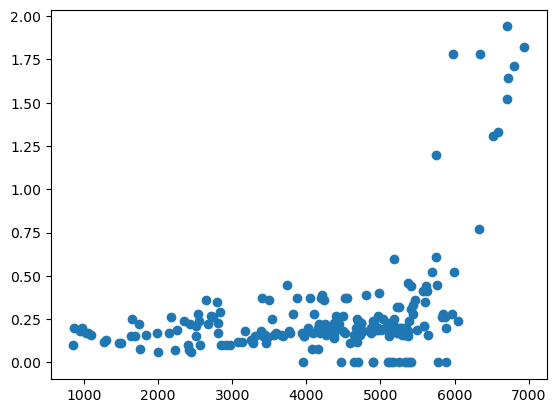

In [52]:
import matplotlib.pyplot as plt
plt.scatter(z, prec)

In [376]:
# Make a net cdf file for eachyear for each variable

for i in datasets_years.keys():
    for j in datasets_years[i].keys():
        datasets_years[i][j].to_netcdf(home_dir + '/Downloads/' + f'{i}_' + f'{j}.nc')

In [379]:
# Create zip files for each netcdf file

for i in datasets_years.keys():
    for j in datasets_years[i].keys():

      # Create a ZipFile Object
      with ZipFile(f'/Users/jacobqs/Downloads/{i}_{j}.nc.zip', 'w') as zip_object:
         # Adding files that need to be zipped
         zip_object.write(f'/Users/jacobqs/Downloads/{i}_{j}.nc')


      # Check to see if the zip file is created
      if os.path.exists(f'/Users/jacobqs/Downloads/{i}_{j}.nc.zip'):
         print("ZIP file created")
      else:
         print("ZIP file not created")

ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file created
ZIP file creat